# setup

## library

In [119]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
plt.rcParams['font.family'] = 'Malgun Gothic'

import seaborn as sns 

from datetime import datetime
from pytimekr import pytimekr

import folium
from folium import plugins
import json

from scipy.stats import chisquare

## load dataset

In [120]:
train = pd.read_csv('../dataset/train.csv')
train.head()

,date,area,sex,frequency,ob_avg_tca,ob_ssrate,ob_sum_gsr,ob_avg_pa,ob_max_pa,ob_min_pa,...,ob_avg_ws,ob_max_ws,습도,최고기온,최저기온,ob_O3,ob_pm10,year,65세이상인구,전체인구
0,2012-01-01,강원,1,3,6.48,37.945455,7.1325,994.354545,996.381818,991.163636,...,2.063636,5.072727,65.000000,1.50,-10.9,0.0191,63.822062,2012,241694,1538630
1,2012-01-01,강원,2,3,6.48,37.945455,7.1325,994.354545,996.381818,991.163636,...,2.063636,5.072727,65.000000,1.50,-10.9,0.0191,63.822062,2012,241694,1538630
2,2012-01-02,강원,1,2,3.36,63.400000,8.2950,996.618182,998.872727,994.845454,...,1.509091,3.500000,62.352941,-0.95,-12.4,0.0172,68.328993,2012,241694,1538630
3,2012-01-02,강원,2,0,3.36,63.400000,8.2950,996.618182,998.872727,994.845454,...,1.509091,3.500000,62.352941,-0.95,-12.4,0.0172,68.328993,2012,241694,1538630
4,2012-01-03,강원,1,0,6.00,53.200000,7.8750,991.745455,995.218182,988.663636,...,1.981818,5.227273,60.294118,-1.40,-10.4,0.0182,77.407118,2012,241694,1538630


# EDA

## target 시점 변환

- 날짜별 당일의 frequency를 target으로 사용할 다음날의 frequency로 변환함

In [121]:
tmp = train.sort_values(by=['area','sex'])
area_lst = train['area'].unique()
sex_lst = train['sex'].unique()

stack_df = pd.DataFrame()
for area in area_lst:
    for sex in sex_lst:
        tmp_df = tmp[(tmp['area'] == area) & (tmp['sex'] == sex)]
        tmp_df['frequency'] = tmp_df['frequency'].shift(-1)
        tmp_df = tmp_df[~tmp_df['frequency'].isnull()]
        stack_df = pd.concat([stack_df, tmp_df])

In [123]:
train = stack_df
train = train.reset_index(drop = True)
train

,date,area,sex,frequency,ob_avg_tca,ob_ssrate,ob_sum_gsr,ob_avg_pa,ob_max_pa,ob_min_pa,...,ob_avg_ws,ob_max_ws,습도,최고기온,최저기온,ob_O3,ob_pm10,year,65세이상인구,전체인구
0,2012-01-01,강원,1,2.0,6.48,37.945455,7.1325,994.354545,996.381818,991.163636,...,2.063636,5.072727,65.000000,1.500000,-10.90,0.0191,63.822062,2012,241694,1538630
1,2012-01-02,강원,1,0.0,3.36,63.400000,8.2950,996.618182,998.872727,994.845454,...,1.509091,3.500000,62.352941,-0.950000,-12.40,0.0172,68.328993,2012,241694,1538630
2,2012-01-03,강원,1,1.0,6.00,53.200000,7.8750,991.745455,995.218182,988.663636,...,1.981818,5.227273,60.294118,-1.400000,-10.40,0.0182,77.407118,2012,241694,1538630
3,2012-01-04,강원,1,2.0,2.28,75.454545,9.0775,994.490909,997.481818,990.054546,...,2.527273,5.172727,61.764706,0.550000,-10.90,0.0247,64.408104,2012,241694,1538630
4,2012-01-05,강원,1,2.0,0.10,86.372727,10.9900,998.945454,1000.500000,997.127273,...,1.800000,4.372727,61.764706,1.500000,-11.40,0.0221,45.710938,2012,241694,1538630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49635,2015-12-26,충북,2,0.0,NaN,57.000000,7.3300,995.700000,999.550000,993.450000,...,1.875000,5.575000,54.904762,2.033333,-5.75,0.0168,71.003472,2015,234813,1583952
49636,2015-12-27,충북,2,2.0,NaN,84.950000,11.3100,1004.100000,1007.150000,999.450000,...,2.175000,4.375000,60.476190,3.233333,-5.15,0.0187,36.586806,2015,234813,1583952
49637,2015-12-28,충북,2,2.0,NaN,75.750000,9.8800,1007.450000,1008.850000,1006.300000,...,2.525000,6.400000,62.190476,4.533333,-3.10,0.0119,23.097222,2015,234813,1583952
49638,2015-12-29,충북,2,1.0,NaN,79.775000,9.3200,1008.300000,1010.025000,1006.875000,...,1.525000,4.275000,62.857143,5.366667,-2.55,0.0074,29.406250,2015,234813,1583952


## 지역별 환자가 발생하지 않은 날의 비율 분석

In [125]:
train['freq0'] = [1 if s == 0 else 0 for s in train['frequency']]

In [126]:
freq0 = train.groupby('area') ['freq0'].mean().sort_values(ascending = False).to_frame()
freq0

,freq0
area,
세종,0.946575
제주,0.770548
울산,0.626370
대전,0.504110
광주,0.497945
충북,0.391781
강원,0.373630
인천,0.362671
충남,0.346233


- 세종에서 환자가 발생하지 않은 날의 비율은 약 95%에 달하는 높은 수치를 보임
- 따라서 대표적으로 세종의 frequency에 대한 빈도를 살펴보면 다음과 같음

In [127]:
train[train['area'] == '세종']['frequency'].value_counts()

0.0    2764
1.0     149
2.0       7
Name: frequency, dtype: int64

- frequency의 max값 자체도 2로써 크지 않고, 대부분의 날에 환자가 발생하지 않음
- 인구수가 적어 위와 같은 사실이 도출된다고 가정할 수 있고, 이는 지역별 인구수와 발병 빈도의 관계를 통해 확인할 수 있음

### 지역별 인구수와 발병 빈도, 환자가 발생하지 않은 날의 비율

In [128]:
frequency = train.groupby('area') ['frequency'].mean().sort_values()
pop = train.groupby('area')['전체인구'].mean().sort_values()
tmp = pd.merge(frequency, pop, left_on = "area", right_on = "area")
tmp = pd.merge(tmp, freq0, left_on = "area", right_on = "area")
tmp[["전체인구","frequency","freq0"]].sort_values(by="전체인구")

,전체인구,frequency,freq0
area,,,
세종,1.505028e+05,0.055822,0.946575
제주,6.022871e+05,0.272260,0.770548
울산,1.160894e+06,0.465753,0.626370
광주,1.472550e+06,0.726712,0.497945
대전,1.526998e+06,0.663699,0.504110
강원,1.543703e+06,1.048973,0.373630
충북,1.575299e+06,0.989384,0.391781
전북,1.871897e+06,1.302740,0.282534
전남,1.907892e+06,1.548973,0.235616


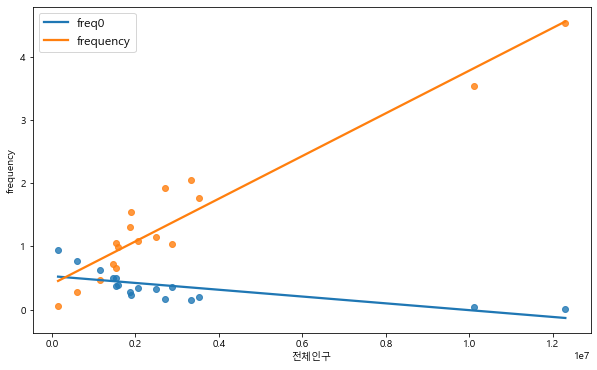

In [129]:
plt.figure(figsize = (10,6))
sns.regplot(x = '전체인구', y = 'freq0', data = tmp, ci=None)
sns.regplot(x = '전체인구', y = 'frequency', data = tmp, ci=None)
plt.legend(['freq0','frequency'], fontsize = "large")

- 인구수에 대해 발병빈도는 비례하고, 환자가 발생하지 않은 날의 비율은 반비례함
- 즉, 지역별 인구수가 발병빈도에 영향을 미치게 됨
- 따라서 인구수의 차이가 큰 두 지역에서 발병빈도가 같다면, 이는 동일한 의미를 가질 수 없음 

## 전체인구, 노인인구 100만 명당 발병 빈도로 target 변환

- 인구 100만명 당 발병 빈도 변수를 생성하여 target이 인구수의 영향을 받지 않도록 함
- 심혈관질환이 노인인구에 대해 많이 발생한다고 알려져 있으므로 전체인구, 노인인구 100만명 당 발병 빈도 변수를 각각 생성하여 비교

In [130]:
train['전체인구100만명'] = train['frequency'] / train['전체인구'] * 1000000
train['노인인구100만명'] = train['frequency'] / train['65세이상인구'] * 1000000

In [131]:
train

,date,area,sex,frequency,ob_avg_tca,ob_ssrate,ob_sum_gsr,ob_avg_pa,ob_max_pa,ob_min_pa,...,최고기온,최저기온,ob_O3,ob_pm10,year,65세이상인구,전체인구,freq0,전체인구100만명,노인인구100만명
0,2012-01-01,강원,1,2.0,6.48,37.945455,7.1325,994.354545,996.381818,991.163636,...,1.500000,-10.90,0.0191,63.822062,2012,241694,1538630,0,1.299858,8.274926
1,2012-01-02,강원,1,0.0,3.36,63.400000,8.2950,996.618182,998.872727,994.845454,...,-0.950000,-12.40,0.0172,68.328993,2012,241694,1538630,1,0.000000,0.000000
2,2012-01-03,강원,1,1.0,6.00,53.200000,7.8750,991.745455,995.218182,988.663636,...,-1.400000,-10.40,0.0182,77.407118,2012,241694,1538630,0,0.649929,4.137463
3,2012-01-04,강원,1,2.0,2.28,75.454545,9.0775,994.490909,997.481818,990.054546,...,0.550000,-10.90,0.0247,64.408104,2012,241694,1538630,0,1.299858,8.274926
4,2012-01-05,강원,1,2.0,0.10,86.372727,10.9900,998.945454,1000.500000,997.127273,...,1.500000,-11.40,0.0221,45.710938,2012,241694,1538630,0,1.299858,8.274926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49635,2015-12-26,충북,2,0.0,NaN,57.000000,7.3300,995.700000,999.550000,993.450000,...,2.033333,-5.75,0.0168,71.003472,2015,234813,1583952,1,0.000000,0.000000
49636,2015-12-27,충북,2,2.0,NaN,84.950000,11.3100,1004.100000,1007.150000,999.450000,...,3.233333,-5.15,0.0187,36.586806,2015,234813,1583952,0,1.262665,8.517416
49637,2015-12-28,충북,2,2.0,NaN,75.750000,9.8800,1007.450000,1008.850000,1006.300000,...,4.533333,-3.10,0.0119,23.097222,2015,234813,1583952,0,1.262665,8.517416
49638,2015-12-29,충북,2,1.0,NaN,79.775000,9.3200,1008.300000,1010.025000,1006.875000,...,5.366667,-2.55,0.0074,29.406250,2015,234813,1583952,0,0.631332,4.258708


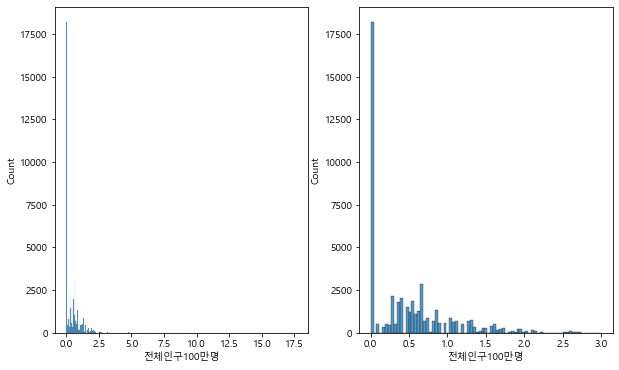

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.histplot(x = '전체인구100만명', data = train, ax = ax[0])
sns.histplot(x = '전체인구100만명', data = train[train['전체인구100만명'] < 3], ax = ax[1])
plt.show()

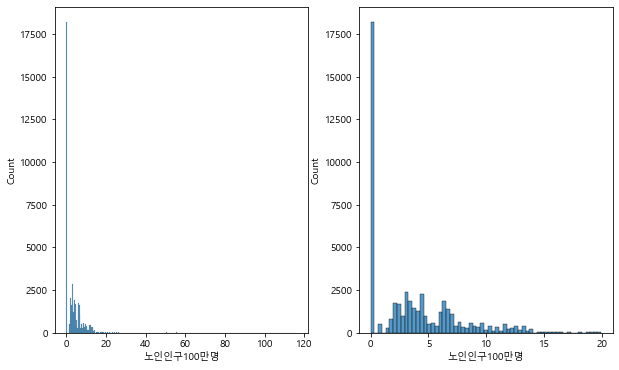

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.histplot(x = '노인인구100만명', data = train, ax = ax[0])
sns.histplot(x = '노인인구100만명', data = train[train['노인인구100만명'] < 20], ax = ax[1])
plt.show()

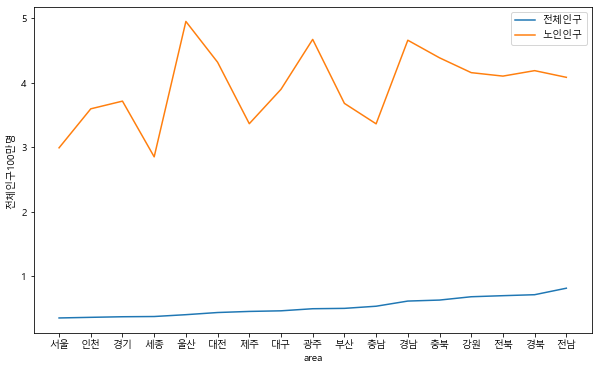

In [134]:
tmp = train.groupby('area')['전체인구100만명', '노인인구100만명'].mean().sort_values(by = '전체인구100만명').reset_index()

plt.figure(figsize = (10,6))
sns.lineplot(x = tmp['area'], y = tmp['전체인구100만명'], data = tmp, label = '전체인구')
sns.lineplot(x = tmp['area'], y = tmp['노인인구100만명'], data = tmp, label = '노인인구')
plt.legend()
plt.show()

- 지역별로 편차가 크지 않은 전체인구100만명 변수를 target으로 사용
- 지역별로 target이 갖는 의미는 최대한 동일해야 하므로 모든 지역을 통합해서 modeling해도 비슷한 확률을 예측할 수 있고, 인구수에 비례한 발병 빈도 출력 가능

## target의 outlier 제거

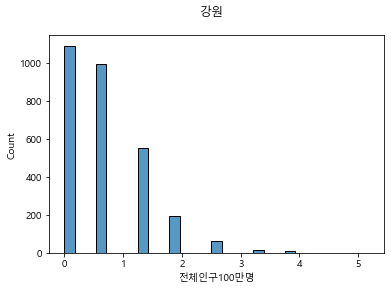

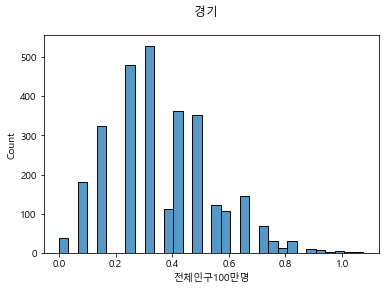

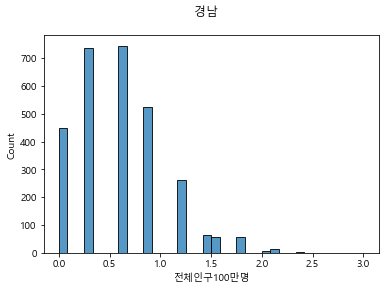

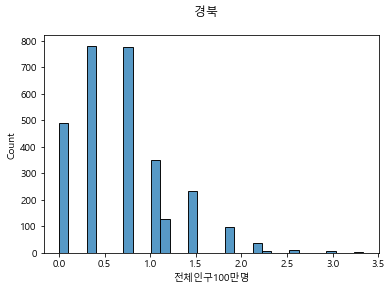

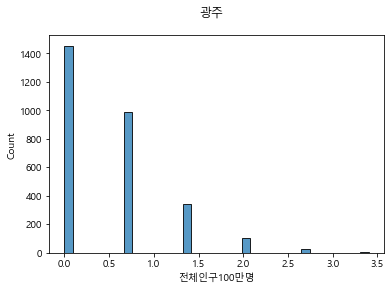

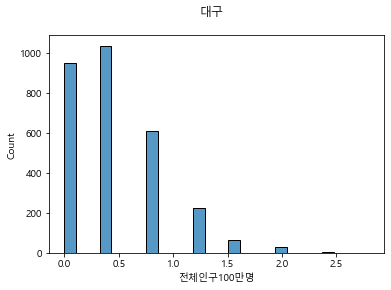

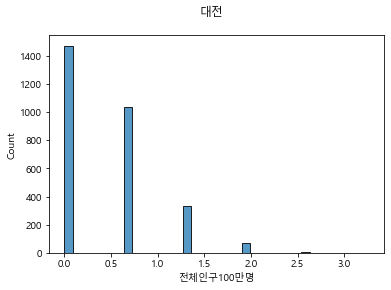

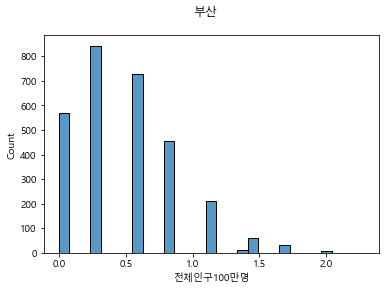

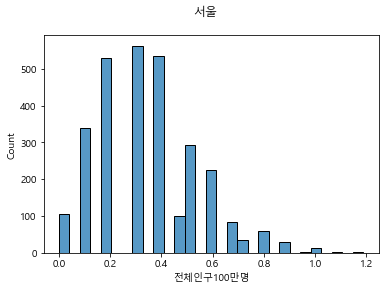

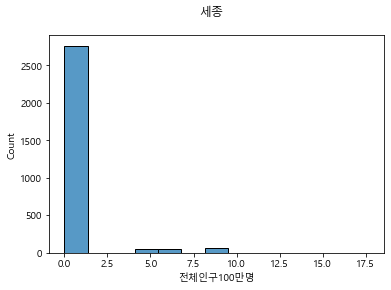

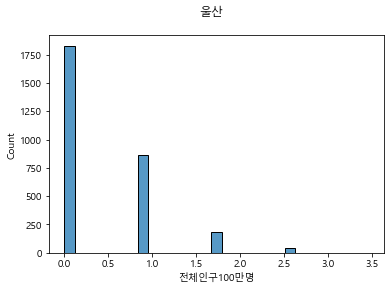

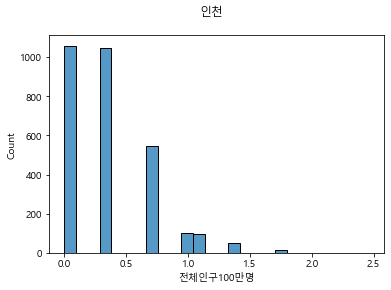

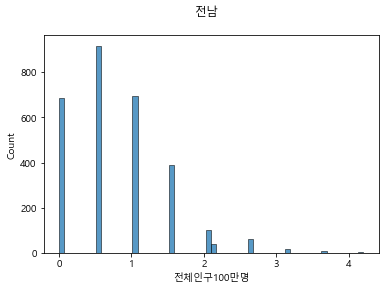

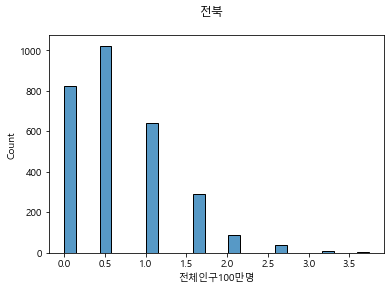

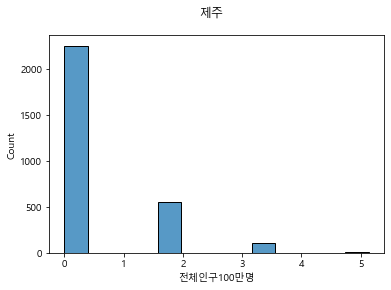

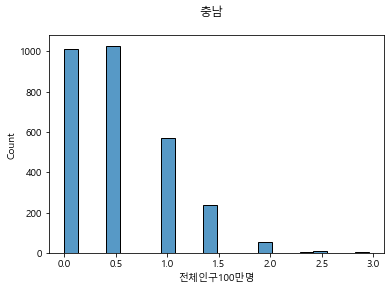

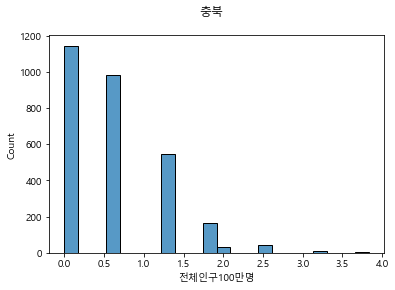

In [135]:
for area in train['area'].unique() :
    sns.histplot(x = '전체인구100만명', data = train[train['area'] == area],
                 label = '전체인구')
    plt.suptitle(area)
    plt.show()

- 전체적으로 target이 0명인 날의 빈도가 압도적으로 높기 때문에 이를 handling할 필요가 있음
- 세종의 전체인구 100만명 당 빈도수의 range가 다른 지역들보다 큼

In [25]:
train[train['전체인구100만명'] > 5]['area'].value_counts()

세종    109
제주      8
강원      1
Name: area, dtype: int64

- 전체인구 100만명당 빈도수의 값이 눈에띄게 큰 값을 가지는 데이터들은 outlier로 정의하여 제거할 필요가 있음

### 지역별 상위 1% 제거

- outlier를 처리하기 위해 우선 지역별 상위 1%를 제거함

In [136]:
outlier_dict = train.groupby('area')['frequency'].quantile(0.99).to_dict()
train['outlier'] = [outlier_dict[s] for s in train['area']]
train['outlier'] = (train['frequency'] < train['outlier'])
train = train[train['outlier'] == True]

###  최종 train의 상위 0.5%인 경우 제거

- 최종 train에서 인구 100만명당 발병빈도가 상위 0.5%인 경우를 한번 더 제거해 줌으로써 outlier 처리

<AxesSubplot:xlabel='frequency', ylabel='Count'>

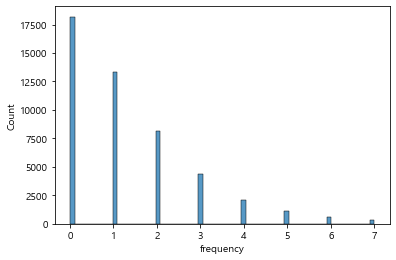

In [138]:
top_1percent =  train['frequency'].quantile(0.995)
train = train[train['frequency'] < top_1percent]
sns.histplot(x = 'frequency', data = train)

## 경제수준 변수 추가

- 「사회경제적 수준과 당뇨병 및 심혈관 질환과의 관계」 중 심혈관질환과 경제수준이 관련있다는 논문 내용에 근거해 두 변수 사이의 상관관계를 살펴봄

In [139]:
income = pd.read_csv('../dataset/income.csv')
income

,area,year,income
0,서울,2012,18795
1,서울,2013,19525
2,서울,2014,19832
3,서울,2015,20857
4,서울,2016,21295
...,...,...,...
80,제주,2012,14383
81,제주,2013,14829
82,제주,2014,15329
83,제주,2015,16685


In [140]:
train = pd.merge(train, income, left_on = ['area', 'year'], right_on = ['area', 'year'], 
                 how = 'left')

<AxesSubplot:xlabel='income', ylabel='전체인구100만명'>

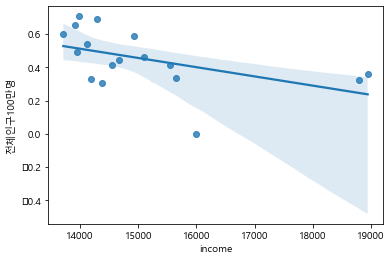

In [141]:
tmp = train[train['year'] == 2012].groupby('area')['income', '전체인구100만명'].mean()
sns.regplot(x = 'income', y = '전체인구100만명', data = tmp)

- 그래프를 통해 경제수준과 전체인구 100만명 당 발병빈도는 음의 상관관계가 있다는 것을 알 수 있음

In [142]:
train.groupby('area')['income', '전체인구100만명'].mean().corr()

,income,전체인구100만명
income,1.000000,-0.677689
전체인구100만명,-0.677689,1.000000


- 경제수준과 발병 빈도는 꽤 높은 상관관계를 가짐
- 경제수준을 모델을 학습시키기 위한 변수로 추가할 수 있음

## year, month, day, 요일 변수 생성

- year, month, day, 요일별 빈도수를 분석하기 위해 변수 생성

In [143]:
train['year'] = [np.int(s[0:4]) for s in train['date']]
train['month'] = [np.int(s[5:7]) for s in train['date']]
train['day'] = [np.int(s[8:10]) for s in train['date']]

In [144]:
weekday_lst = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun','Mon']
train['weekday'] = [weekday_lst[datetime.strptime(date, '%Y-%m-%d').weekday()+1] for date in \
                    train['date']]
train['weekend'] = [1 if weekday in ['Sat', 'Sun'] else 0 for weekday in train['weekday']]

### 연도별 분석

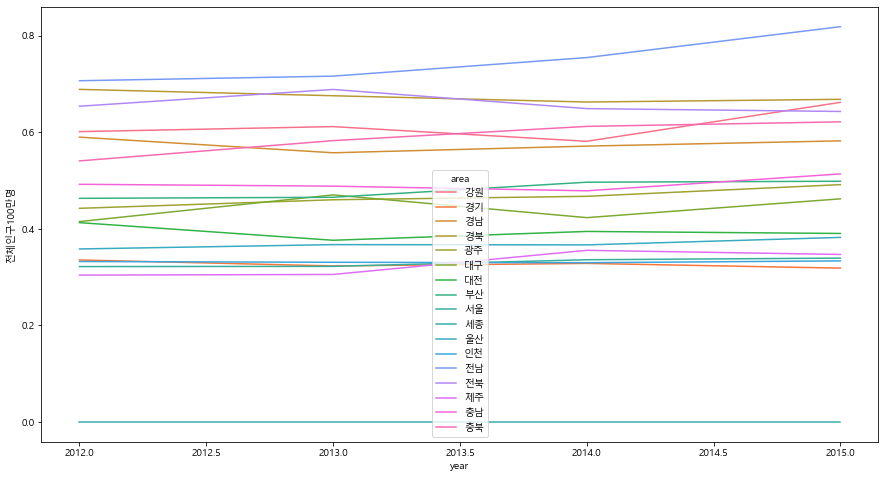

In [145]:
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'year', y = '전체인구100만명', hue = 'area', data = train, ci=None)
plt.show()

- 연도에 따른 발병빈도에서 유의미한 결과를 도출하기 어려움

### 월별 분석

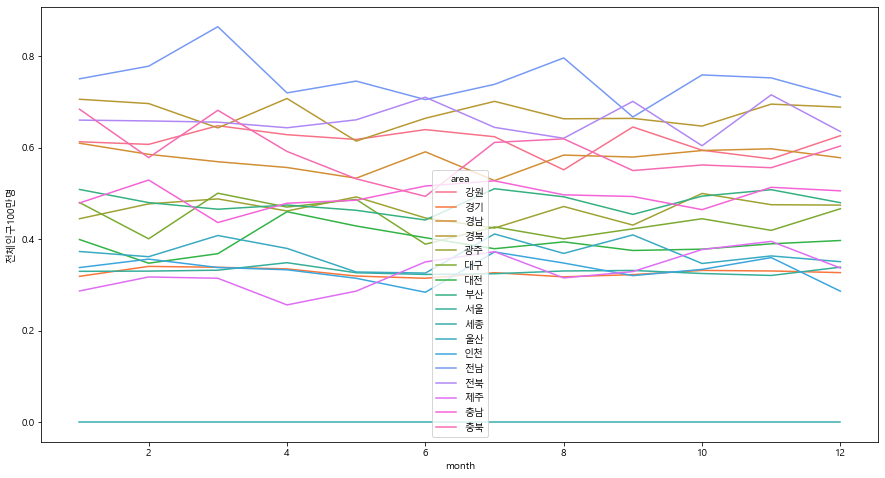

In [146]:
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'month', y = '전체인구100만명', hue = 'area', data = train, ci = None)
plt.show()

- 월별에 따른 발병빈도 역시 유의미한 결과를 찾기 어려움

#### 월 변수 코사인변환

- 월변수가 숫자 그대로의 의미가 아닌 계절성이 비슷한 월끼리 유사한 의미를 갖게하기 위해 코사인 변환을 수행한 값 사용

In [147]:
train['month'] = (np.cos((train['month']-3)/8*2*np.pi)+1)/2

### 일별 분석

<AxesSubplot:xlabel='day', ylabel='전체인구100만명'>

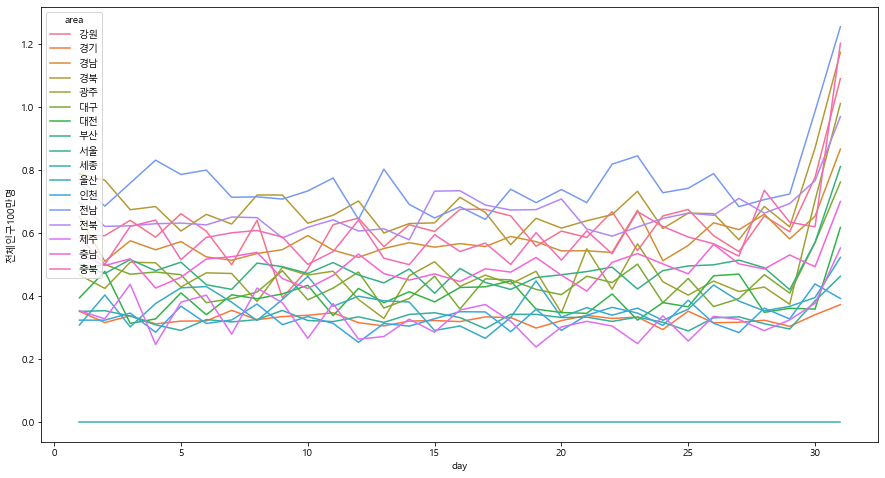

In [148]:
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'day', y = '전체인구100만명', hue = 'area', data = train, ci = None)

- 월말에 예측한 발병 빈도가 급격히 상승함
- 매월의 마지막 날인지 여부에 대한 변수를 생성하여 분석해볼 필요가 있음

#### 매월 마지막날 여부 변수 생성

In [149]:
last_day_lst = ['01-31', '02-28', '02-29', '03-31', '04-30', '05-31', '06-30',
                '07-31', '08-31', '09-30', '10-31', '11-30', '12-31']
train['last_day'] = [1 if str(s)[5:10] in last_day_lst else 0 for s in train['date']]

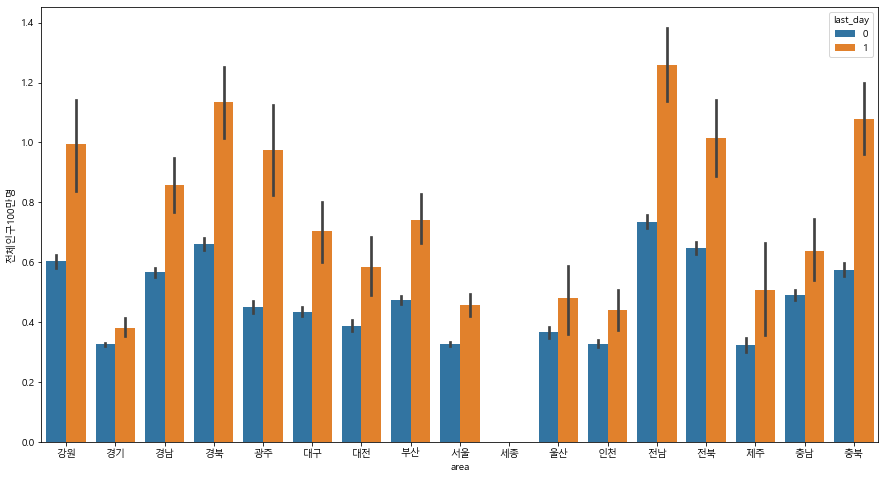

In [150]:
plt.figure(figsize = (15, 8))
sns.barplot(x = 'area', y = '전체인구100만명', hue = 'last_day', data = train)
plt.show()

- 매월의 마지막 날에 예측한 다음날의 발병빈도가 전반적으로 높은 값을 보임

In [37]:
tab = pd.crosstab(train['last_day'], train['freq0'])
print('#'*10, 'frequency', '#'*10)
print(tab, '\n')

print('#'*10, 'percent', '#'*10)
tab2 = np.round(tab.div(tab.sum(axis=1), axis=0)*100, 3)
print(tab2)

result = chisquare(pd.crosstab(train['freq0'], train['last_day']))
print(f'p-value : {result[1][1]}')

########## frequency ##########
freq0         0      1
last_day              
0         30163  17845
1          1289    343 

########## percent ##########
freq0          0       1
last_day                
0         62.829  37.171
1         78.983  21.017
p-value : 2.8691953521028816e-121


- 교차표에 의하면 매월 말일의 다음날에 환자가 발생하지 않은 확률이 말일이 아닌 경우에 비해 약 37%에서 약 21%로 감소함
- 즉, 매월 말일의 다음날에 심혈관 질환 발병 확률이 증가함
- chi-square 검정 시행 결과 독립성에 대한 귀무가설이 기각되므로 두 변수는 연관성이 있음
> 매월 말일에는 다음날의 심혈관 질환 발생 확률이 증가할 것이라고 결론내릴 수 있음

### 요일별 분석

- 예측 대상이 되는 날을 기준으로 요일별, 주말 여부별 발병빈도 비교

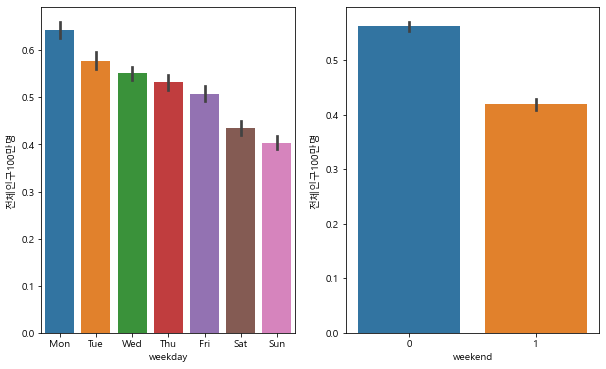

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
sns.barplot(x = 'weekday', y = '전체인구100만명', data = train, ax = ax[0])
sns.barplot(x = 'weekend', y = '전체인구100만명', data = train, ax = ax[1])
plt.show()

- 주말보다 평일에 발생빈도가 높음

## 지역 그룹 변수 생성

- 지역별로 전체인구 대비 발병빈도의 비율을 살펴봄

In [151]:
group_by_ratio = train[['area', '전체인구', 'frequency']]
group_by_ratio['ratio'] = group_by_ratio['frequency'] / group_by_ratio['전체인구']
group_by_ratio = group_by_ratio.groupby('area')['ratio'].mean().to_frame()
group_by_ratio['rank'] = group_by_ratio['ratio'].rank(ascending = False)
group_by_ratio.sort_values(by='rank')

,ratio,rank
area,,
전남,7.491123e-07,1.0
경북,6.737898e-07,2.0
전북,6.585940e-07,3.0
강원,6.139217e-07,4.0
충북,5.890488e-07,5.0
경남,5.751646e-07,6.0
충남,4.932758e-07,7.0
부산,4.809257e-07,8.0
광주,4.653493e-07,9.0


- 전남, 경북, 전북, 강원 순으로 비율이 높음
- 지역별로 발병비율의 차이가 확연히 나타나므로 이를 지도에 표시하여 직관적으로 확인하고자 함

In [152]:
state = json.load(open('state.json', encoding='utf-8'))

In [153]:
korea = folium.Map(location=[35.8, 128], tiles="OpenStreetMap", zoom_start=6.5)
korea.choropleth(geo_data=state,
                 data=group_by_ratio['ratio'],
                 columns=['area'],
                 key_on='feature.properties.CTP_KOR_NM',
                 fill_color='YlOrRd',
                 line_opacity=0.5,
                 legend_name='Rate'
                )
korea

- 발병비율이 비슷한 지역별로 그룹화할 수 있음
- ['강원', '전북', '경북', '전남'], ['충남',' 경남', '충북',], ['대전', '제주', '대구', '광주', '부산'], ['서울', '인천', '경기', '세종', '울산']으로 그룹화하여 총 4개의 그룹 변수 생성

## 노인 인구 대비 발병률에 대한 순위 변수 생성

- 심혈관질환은 비교적 노인층에서 발병하기 쉬운 질환이므로 노인인구 대비 발병률을 기준으로 지역들에 순위를 부여하는 변수를 생성

In [154]:
ratio_by_area = train[['area', '65세이상인구', 'frequency']]
ratio_by_area['ratio'] = ratio_by_area['frequency'] / ratio_by_area['65세이상인구']
ratio_by_area = ratio_by_area.groupby('area')['ratio'].median().to_frame()
ratio_by_area['rank'] = ratio_by_area['ratio'].rank(ascending = False)
ratio_by_area.sort_values(by="rank")

,ratio,rank
area,,
경남,0.000004,1.0
충북,0.000004,2.0
경북,0.000004,3.0
강원,0.000004,4.0
부산,0.000004,5.0
인천,0.000003,6.0
경기,0.000003,7.0
대구,0.000003,8.0
전북,0.000003,9.0


## holiday 변수 생성

- 공휴일의 음주등이 다음날 심혈관질환의 발병에 영향을 미칠 수 있다는 가설을 세울 수 있음
- 이에 대한 분석을 위해 holiday 변수 생성

In [157]:
holiday_lst = []
for year in [2012, 2013, 2014, 2015, 2016] :
    for i in range(len(pytimekr.holidays(year))-1) : 
        hol_lst = np.sort(pytimekr.holidays(year))
        if (hol_lst[i+1] - hol_lst[i]).days > 1 : 
            holiday_lst.append(hol_lst[i])
holiday_lst = [datetime.strftime(s, '%Y-%m-%d') for s in holiday_lst]

# holidays 각각의 일별 평균 frequency과 전체 frequency 평균 비교
avg_hol_freq = train['frequency'].mean()

for hol in holiday_lst : 
    freq = train[train['date'] == hol]['frequency'].mean()
    if freq < avg_hol_freq * 1.1: 
        holiday_lst.remove(hol)
holiday_lst = holiday_lst+['2016-01-01', '2016-02-10', '2016-05-05', '2016-09-16']
holiday_lst

['2012-01-01',
 '2012-01-24',
 '2012-04-28',
 '2012-06-06',
 '2012-08-15',
 '2012-10-01',
 '2012-10-09',
 '2013-01-01',
 '2013-02-11',
 '2013-05-05',
 '2013-06-06',
 '2013-09-20',
 '2013-10-09',
 '2014-01-01',
 '2014-03-01',
 '2014-05-06',
 '2014-08-15',
 '2014-10-03',
 '2015-01-01',
 '2015-03-01',
 '2015-05-25',
 '2015-08-15',
 '2015-10-03',
 '2016-01-01',
 '2016-02-09',
 '2016-03-01',
 '2016-05-05',
 '2016-05-14',
 '2016-06-06',
 '2016-08-15',
 '2016-09-16',
 '2016-10-03',
 '2016-10-09',
 '2016-01-01',
 '2016-02-10',
 '2016-05-05',
 '2016-09-16']

In [158]:
train['holiday'] = [1 if s in holiday_lst else 0 for s in train['date']]

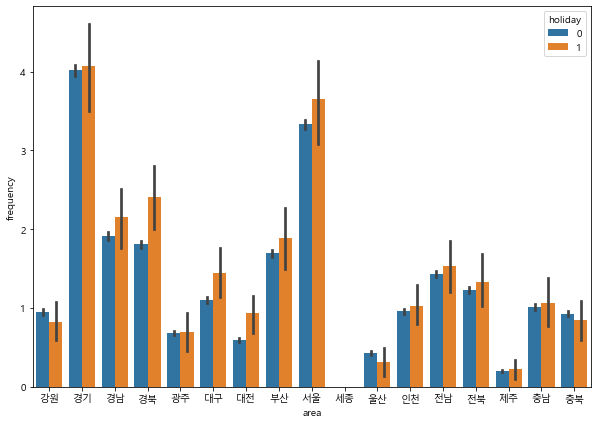

In [159]:
plt.figure(figsize = (10, 7))
sns.barplot(x = 'area', y = 'frequency', hue = 'holiday', data = train)
plt.show()

- 전반적으로 holiday 다음날 심혈관질환의 발병빈도가 증가함

In [160]:
tab = pd.crosstab(train['holiday'], train['freq0'])
print('#'*10, 'frequency', '#'*10)
print(tab, '\n')

print('#'*10, 'percent', '#'*10)
tab2 = np.round(tab.div(tab.sum(axis=1), axis=0)*100, 3)
print(tab2)

result = chisquare(pd.crosstab(train['freq0'], train['holiday']))
print(f'p-value : {result[1][1]}')

########## frequency ##########
freq0        0      1
holiday              
0        29480  17926
1          488    262 

########## percent ##########
freq0         0       1
holiday                
0        62.186  37.814
1        65.067  34.933
p-value : 1.5530561445022225e-16


- 교차표를 통해 holiday 다음날의 발병 빈도가 0일 확률이 holiday가 아닌 날에 비해 약 38%에서 35%로 감소함
- 즉, holiday 다음 날에 심혈관 질환의 발병 확률이 증가함
- chi-square 검정 시행 결과 holiday와 freq0의 변수의 독립성에 대한 귀무가설이 기각되므로 두 변수는 연관성이 있음
> holiday 다음날에는 심혈관 질환 발생 확률이 증가할 것이라고 결론 내릴 수 있음

## 일교차 변수 생성

- 일교차가 심혈관질환에 큰 영향을 미친다는 뉴스 내용에 근거하여 일교차 변수를 생성함(https://news.kbs.co.kr/news/view.do?ncd=2450984)
- 일교차가 같다고 하더라도 최저기온이 더 낮은 경우 심혈관질환 발병빈도가 증가할 것이라는 가정하에 최저기온에 따라 가중치를 부여한 일교차 변수 생성

In [161]:
train['일교차_t'] = (train['ob_max_ta'] - train['ob_min_ta']) / \
(1+np.exp(train['ob_min_ta']/30))
train['일교차_t+1'] = (train['최고기온'] - train['최저기온'])  / \
(1+np.exp(train['최저기온']/30)) 

## 체감온도 변수 생성

- 측정된 기온뿐만 아니라 사람이 실제로 체감하는 온도 역시 심혈관질환 발병에 영향을 미칠것이라는 가정하에 체감온도 변수를 생성함

In [162]:
train['체감온도_t'] = 13.12 + 0.6215 * (train['ob_min_ta']) - 11.37 * \
(train['ob_max_ws'] ** 0.16) + 0.3965 * (train['ob_max_ws'] ** 0.16) *(train['ob_min_ta']) 
train['체감온도_t+1'] = 13.12 + 0.6215 * (train['최저기온']) - 11.37 * \
(train['ob_max_ws'] ** 0.16) + 0.3965 * (train['ob_max_ws'] ** 0.16) *(train['최저기온']) 

## O3, pm10에 대한 지연효과 변수 생성

- O3와 pm10이 당장 내일이 아닌 며칠의 지연효과를 가진다는 논문 결과에 따라 1일, 2일, 3일, 7일, 10일 전의 관측값을 사용하는 변수 생성

In [168]:
tmp = train.sort_values(by = ['area', 'sex'])
area_lst = train['area'].unique()
sex_lst = train['sex'].unique()

stack_df = pd.DataFrame()
for area in area_lst : 
    for sex in sex_lst : 
        tmp_df = tmp[(tmp['area'] == area) & (tmp['sex'] == sex)]
        tmp_df['ob_O3_d-1'] = tmp_df['ob_O3'].shift(1) 
        tmp_df['ob_O3_d-2'] = tmp_df['ob_O3'].shift(2) 
        tmp_df['ob_O3_d-3'] = tmp_df['ob_O3'].shift(3)
        tmp_df['ob_O3_d-7'] = tmp_df['ob_O3'].shift(7)
        tmp_df['ob_O3_d-10'] = tmp_df['ob_O3'].shift(10)
        tmp_df['ob_pm10_d-1'] = tmp_df['ob_pm10'].shift(1) 
        tmp_df['ob_pm10_d-2'] = tmp_df['ob_pm10'].shift(2) 
        tmp_df['ob_pm10_d-3'] = tmp_df['ob_pm10'].shift(3) 
        tmp_df['ob_pm10_d-7'] = tmp_df['ob_pm10'].shift(7)
        tmp_df['ob_pm10_d-10'] = tmp_df['ob_pm10'].shift(10)
        stack_df = pd.concat([stack_df, tmp_df], axis = 0)
train = stack_df

## 결측치 처리

In [49]:
train.isnull().sum()

date                 0
area                 0
sex                  0
frequency            0
ob_avg_tca        3932
ob_ssrate            2
ob_sum_gsr        2950
ob_avg_pa            2
ob_max_pa            0
ob_min_pa            0
ob_avg_rhm           4
ob_min_rhm           2
ob_sum_rn        27106
ob_sum_rn_dur    30140
ob_avg_ta            2
ob_max_ta            2
ob_min_ta            0
ob_min_vs         3484
ob_avg_ws           10
ob_max_ws            2
습도                2448
최고기온              2448
최저기온              2510
ob_O3                0
ob_pm10            382
year                 0
65세이상인구              0
전체인구                 0
freq0                0
전체인구100만명            0
노인인구100만명            0
income               0
month                0
day                  0
last_day             0
weekday              0
weekend              0
holiday              0
일교차_t                2
일교차_t+1           2510
dtype: int64

- 강수량의 결측치가 많아 행을 삭제하여 처리하기 어려움
- 따라서 강수량과 연관된 습도를 통한 예측값으로 결측값 처리가 가능한지에 대해 분석이 필요함
- 강수량 외의 결측치를 가진 다른 변수들은 KNN을 사용하여 결측치 처리

### 강수량 결측치 처리

In [169]:
print("#"*10, "averagge of ob_avg_rhm", "#"*10)
print("NA :", train[train['ob_sum_rn'].isnull()]['ob_avg_rhm'].mean())
print("강수 X :", train[train['ob_sum_rn'] == 0]['ob_avg_rhm'].mean())
print("강수 O:", train[train['ob_sum_rn'] > 60]['ob_avg_rhm'].mean())

########## averagge of ob_avg_rhm ##########
NA : 60.83875873556728
강수 X : 65.27951236426468
강수 O: 90.76150375123777


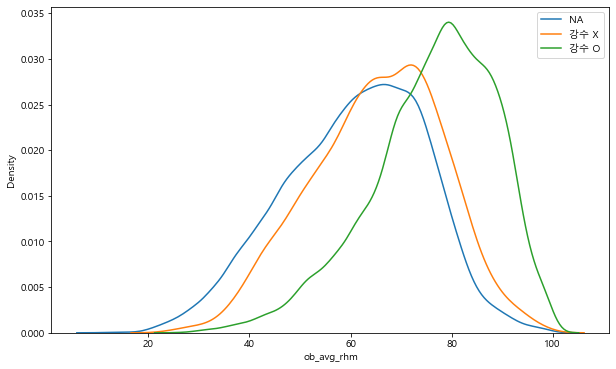

In [170]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = train[train['ob_sum_rn'].isnull()]['ob_avg_rhm'], label = 'NA')
sns.kdeplot(x = train[train['ob_sum_rn'] == 0]['ob_avg_rhm'], label = '강수 X')
sns.kdeplot(x = train[train['ob_sum_rn'] > 0]['ob_avg_rhm'], label = '강수 O')
plt.legend()
plt.show()

- 강수량이 결측값을 가지는 경우의 상대습도는 강수량이 0인 경우의 상대습도와 분포가 비슷함
> 강수량의 결측값을 0으로 채울 수 있음